# Unified Model with Multiple Strategic Agents: Real Data Example

James Yu, 19 February 2025

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import us
np.set_printoptions(suppress=True)

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol = 300):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    max_distances = defaultdict(list)
    counter = 0
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        cd_K = [np.max(np.abs(K_t[l] - K_new[l])) for l in range(L)]
        cd_k = [np.max(np.abs(k_t[l] - k_new[l])) for l in range(L)]
        cd_kappa = [np.max(np.abs(kappa_t[l] - kappa_new[l])) for l in range(L)]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new
        historical_K.insert(0, K_t)
        historical_k.insert(0, k_t)
        historical_kappa.insert(0, kappa_t)
        for l in range(L):
            max_distances[(l+1, "K")].append(cd_K[l])
            max_distances[(l+1, "k")].append(cd_k[l])
            max_distances[(l+1, "kappa")].append(cd_kappa[l])
        counter += 1
        if sum(cd_K + cd_k + cd_kappa) == 0 or counter > tol:
            return max_distances, historical_K, historical_k, historical_kappa

In [5]:
def optimal(X_init, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c, infinite = True):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(lambda: 0)
    i = 0
    while [i < len(historical_K), True][infinite]:
        K_t = historical_K[[i, 0][infinite]]
        k_t = historical_k[[i, 0][infinite]]
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if infinite == True and np.max(X_t[l] - X_new) == 0 and l == L - 1:
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def run_simulation(A, X_0_1, b2):
    X_0 = [X_0_1, X_0_1 - b2]
    delta = 0.9 # discount rate
    c_cost = 1 # message cost
    n = X_0_1.shape[0] # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [c_cost * np.identity(n), c_cost * np.identity(n)] # message cost R = cI_n for some c under the new notation
    B = [np.identity(n), np.identity(n)] # direct message broadcasting
    x = [0, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
    xs, rs, payoffs = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)
    return xs[0], rs, payoffs
    #print(xs[0][-1])
    

In [7]:
network_matrix = pd.read_csv("state_net_adjacency.csv")

In [8]:
state_label_list = list(network_matrix.columns[1:])
state_name_list = []
for state_label in state_label_list:
    if state_label == "DC":
        state_name_list.append("District of Columbia")
    else:
        state_name_list.append(us.states.lookup(state_label).name)

In [9]:
initial_x_data = pd.read_csv("YCOM7_publicdata.csv")

In [10]:
state_opinion_map = {}
for row in initial_x_data.iterrows():
    if row[1]["geoname"] in state_name_list:
        state_opinion_map[row[1]["geoname"]] = row[1]["consensusOppose"]

state_opinion_map

{'Alabama': 27.95,
 'Alaska': 24.83,
 'Arizona': 25.04,
 'Arkansas': 28.93,
 'California': 20.41,
 'Colorado': 23.02,
 'Connecticut': 21.35,
 'Delaware': 23.52,
 'District of Columbia': 15.46,
 'Florida': 24.26,
 'Georgia': 23.67,
 'Hawaii': 21.37,
 'Idaho': 29.87,
 'Illinois': 22.39,
 'Indiana': 29.06,
 'Iowa': 27.53,
 'Kansas': 27.95,
 'Kentucky': 30.16,
 'Louisiana': 25.9,
 'Maine': 24.72,
 'Maryland': 19.4,
 'Massachusetts': 19.85,
 'Michigan': 24.59,
 'Minnesota': 23.85,
 'Mississippi': 26.22,
 'Missouri': 27.57,
 'Montana': 28.45,
 'Nebraska': 28.35,
 'Nevada': 25.28,
 'New Hampshire': 24.29,
 'New Jersey': 20.85,
 'New Mexico': 25.35,
 'New York': 20.08,
 'North Carolina': 24.11,
 'North Dakota': 32.61,
 'Ohio': 26.76,
 'Oklahoma': 30.14,
 'Oregon': 22.67,
 'Pennsylvania': 24.49,
 'Rhode Island': 23.9,
 'South Carolina': 26.28,
 'South Dakota': 29.46,
 'Tennessee': 28.29,
 'Texas': 24.77,
 'Utah': 28.69,
 'Vermont': 22.07,
 'Virginia': 22.33,
 'Washington': 21.7,
 'West Virginia

In [11]:
X_0_1_data = []
# iterate over the states as ordered in the matrix 
# to ensure the initial opinions have the same order
for state_label in state_label_list:
    if state_label == "DC":
        state_name = "District of Columbia"
    else:
        state_name = us.states.lookup(state_label).name
    X_0_1_data.append(state_opinion_map[state_name])

print(X_0_1_data) # the initial opinions

[24.83, 27.95, 28.93, 25.04, 20.41, 23.02, 21.35, 15.46, 23.52, 24.26, 23.67, 21.37, 27.53, 29.87, 22.39, 29.06, 27.95, 30.16, 25.9, 19.85, 19.4, 24.72, 24.59, 23.85, 27.57, 26.22, 28.45, 24.11, 32.61, 28.35, 24.29, 20.85, 25.35, 25.28, 20.08, 26.76, 30.14, 22.67, 24.49, 23.9, 26.28, 29.46, 28.29, 24.77, 28.69, 22.33, 22.07, 21.7, 25.9, 33.71, 33.24]


In [12]:
X_0_1_numpy = np.array([X_0_1_data], ndmin = 2).T

In [13]:
A_data = network_matrix.to_numpy()[:, 1:].astype(np.float64)

In [14]:
A_data

array([[0.45950087, 0.00698945, 0.00479319, ..., 0.0091629 , 0.00203207,
        0.00300008],
       [0.00057838, 0.68728663, 0.00356649, ..., 0.00252862, 0.00111391,
        0.00034574],
       [0.00075465, 0.0067856 , 0.64754348, ..., 0.00402283, 0.00094993,
        0.00065503],
       ...,
       [0.00096402, 0.00321485, 0.00268821, ..., 0.65677675, 0.00076099,
        0.00075061],
       [0.00060578, 0.00401288, 0.00179866, ..., 0.00215628, 0.60770641,
        0.00050837],
       [0.00316044, 0.00440139, 0.00438285, ..., 0.00751585, 0.00179647,
        0.44020426]])

In [15]:
A_data[0, :] # first row

array([0.45950087, 0.00698945, 0.00479319, 0.02110471, 0.05543452,
       0.01966996, 0.00274554, 0.00130255, 0.00101112, 0.0261343 ,
       0.01459634, 0.01004995, 0.0041367 , 0.01223794, 0.0110416 ,
       0.00670229, 0.00479014, 0.00463437, 0.00626128, 0.00606396,
       0.00588541, 0.00288865, 0.01252192, 0.01262544, 0.00881115,
       0.00385955, 0.00864238, 0.01431582, 0.0027795 , 0.00338347,
       0.00200501, 0.00539467, 0.00511521, 0.00960488, 0.01468289,
       0.01113458, 0.0074019 , 0.02484694, 0.01215497, 0.00091786,
       0.00742014, 0.00261015, 0.00986565, 0.03868826, 0.01326547,
       0.01205095, 0.0013753 , 0.05235607, 0.0091629 , 0.00203207,
       0.00300008])

In [16]:
A_data[:, 0] # first column

array([0.45950087, 0.00057838, 0.00075465, 0.00201949, 0.00110587,
       0.00206204, 0.00048504, 0.00076749, 0.00057339, 0.0007869 ,
       0.00063218, 0.00464912, 0.00077263, 0.00437934, 0.0004828 ,
       0.00056973, 0.00099685, 0.00054648, 0.00054072, 0.0005498 ,
       0.00057357, 0.00144352, 0.00073689, 0.00137427, 0.00077227,
       0.00044432, 0.00478749, 0.00067754, 0.00209138, 0.00102601,
       0.00101943, 0.00039696, 0.00155755, 0.00214323, 0.00043819,
       0.00053619, 0.00105967, 0.00442524, 0.00055459, 0.00053283,
       0.00060787, 0.0016853 , 0.00068097, 0.00080354, 0.00227411,
       0.0007841 , 0.00141126, 0.00497437, 0.00096402, 0.00060578,
       0.00316044])

In [17]:
A_data.shape

(51, 51)

In [18]:
xs, rs, payoffs = run_simulation(A_data, X_0_1_numpy, 50)

In [19]:
xs[-1].T # steady-state opinions

array([[25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.]])

In [20]:
len(xs) # time periods before convergence

29

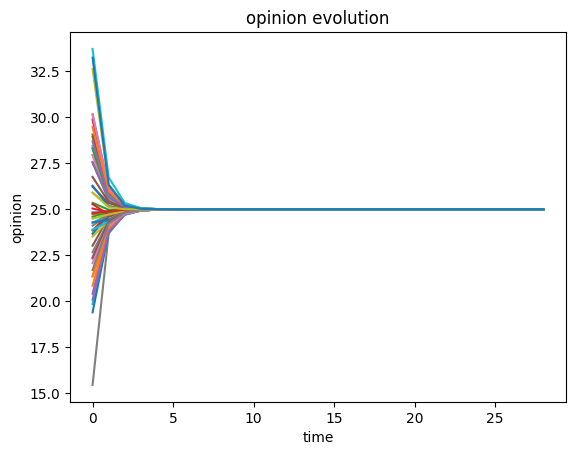

In [21]:
time_grid = range(len(xs))

for state in range(51):
    plt.plot(time_grid, [xs[t][state, 0] for t in time_grid])

plt.xlabel("time")
plt.ylabel("opinion")
plt.title("opinion evolution")
plt.show()

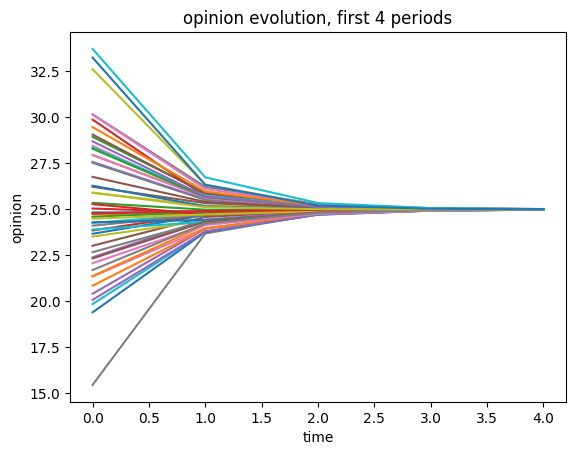

In [22]:
time_grid_short = range(5)
for state in range(51):
    plt.plot(time_grid_short, [xs[t][state, 0] for t in time_grid_short])

plt.xlabel("time")
plt.ylabel("opinion")
plt.title("opinion evolution, first 4 periods")
plt.show()

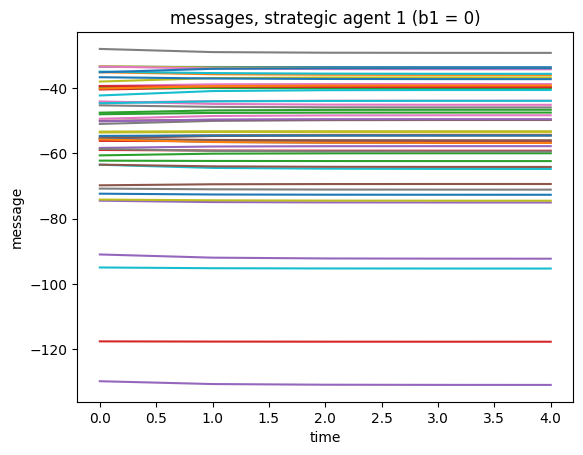

In [23]:
time_grid = range(5)
for state in range(51):
    plt.plot(time_grid, [rs[0][t][state, 0] for t in time_grid])

plt.xlabel("time")
plt.ylabel("message")
plt.title("messages, strategic agent 1 (b1 = 0)")
plt.show()

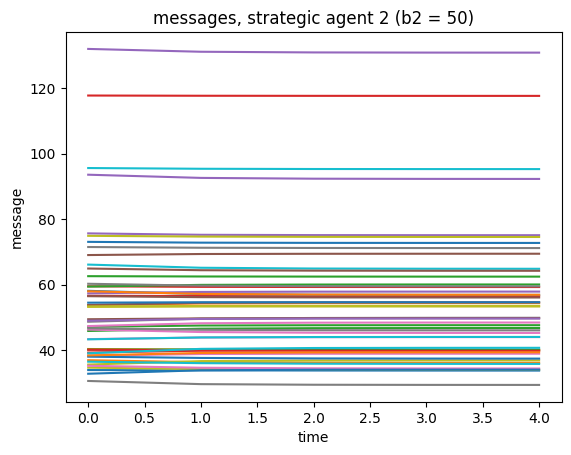

In [24]:
time_grid = range(5)
for state in range(51):
    plt.plot(time_grid, [rs[1][t][state, 0] for t in time_grid])

plt.xlabel("time")
plt.ylabel("message")
plt.title("messages, strategic agent 2 (b2 = 50)")
plt.show()

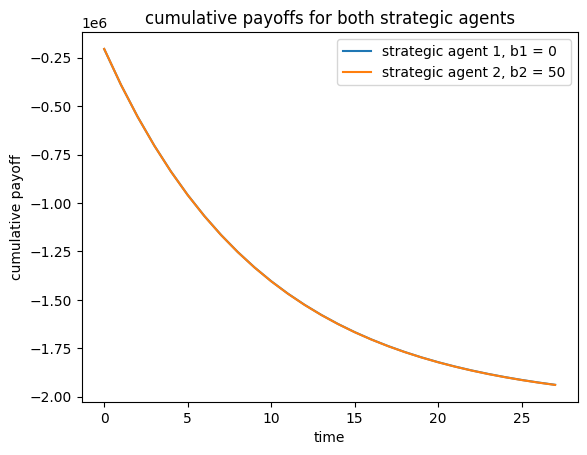

In [25]:
plt.plot(range(len(payoffs[0])), payoffs[0], label = "strategic agent 1, b1 = 0")
plt.plot(range(len(payoffs[1])), payoffs[1], label = "strategic agent 2, b2 = 50")
plt.xlabel("time")
plt.ylabel("cumulative payoff")
plt.title("cumulative payoffs for both strategic agents")
plt.legend()
plt.show()

### NOTE: The labels on the above plot's y-axis should be multiplied by $10^6$ to be interpreted.

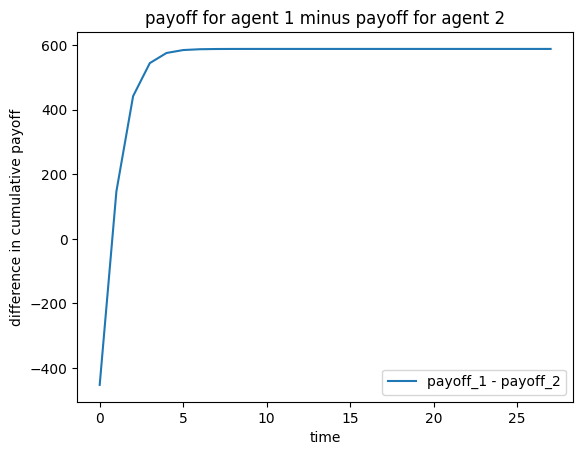

In [26]:
plt.plot(range(len(payoffs[0])), [payoffs[0][i] - payoffs[1][i] for i in range(len(payoffs[0]))], label = "payoff_1 - payoff_2")
plt.xlabel("time")
plt.ylabel("difference in cumulative payoff")
plt.legend()
plt.title("payoff for agent 1 minus payoff for agent 2")
plt.show()

In [27]:
# OPINIONS
for i, opinion_vec in enumerate(xs):
    print(f"t = {i}:", opinion_vec.T)

t = 0: [[24.83 27.95 28.93 25.04 20.41 23.02 21.35 15.46 23.52 24.26 23.67 21.37
  27.53 29.87 22.39 29.06 27.95 30.16 25.9  19.85 19.4  24.72 24.59 23.85
  27.57 26.22 28.45 24.11 32.61 28.35 24.29 20.85 25.35 25.28 20.08 26.76
  30.14 22.67 24.49 23.9  26.28 29.46 28.29 24.77 28.69 22.33 22.07 21.7
  25.9  33.71 33.24]]
t = 1: [[24.83958512 25.65516685 25.90290266 24.84530434 23.9494148  24.58469494
  23.97767581 23.68804401 24.38093371 24.73604918 24.68422612 24.15269369
  25.51594611 25.7070963  24.43892831 25.84555626 25.63677661 26.2157257
  25.19135265 23.78728119 23.76460567 24.70453849 24.87050236 24.75027558
  25.5424295  25.33482132 25.61116254 24.71347072 26.3377547  25.74356703
  24.41822904 23.94569651 24.97650527 24.71058079 23.79916479 25.40276733
  26.10235486 24.36230997 24.7204707  24.3223383  25.16171529 25.96644918
  25.66079069 24.90769563 25.69903497 24.32719541 24.15632864 24.23178753
  25.11565933 26.7350841  26.32893673]]
t = 2: [[24.93167793 25.14179756 25.20

In [28]:
for i in range(len(rs[0])):
    print(f"t = {i}:")
    print("  strategic agent 1:", rs[0][i].T)
    print("  strategic agent 2:", rs[1][i].T)
    print()

t = 0:
  strategic agent 1: [[ -33.5106556   -54.98475079  -47.58557408  -56.22641587 -129.80358814
   -55.63314585  -44.14832383  -28.07090089  -33.34591075  -94.98299944
   -72.39195479  -35.20308295  -48.06786686  -40.49697619  -74.53470962
   -55.39889564  -44.54453704  -51.03795171  -53.65576716  -63.53024232
   -55.57235044  -39.62595881  -62.27300969  -59.00514274  -58.37864607
   -50.06202957  -39.40973957  -70.83070209  -38.06400513  -44.70552752
   -36.73374035  -55.77438087  -40.04153004  -39.44503261  -90.9978161
   -69.82678859  -49.46121251  -45.34708524  -74.1927398   -35.01830079
   -54.70631585  -40.20467574  -60.65951686 -117.60316333  -50.25735085
   -63.50272453  -33.47449852  -58.69061542  -53.38101426  -42.32166308
   -35.21257295]]
  strategic agent 2: [[ 33.83991901  53.69579709  45.79771164  56.56874632 132.07937363
   56.43569583  46.22707221  30.50133853  34.57567186  95.64048165
   73.05640879  36.85096767  47.05185041  39.18251677  75.64856788
   53.7485030

In [29]:
# CUMULATIVE PAYOFFS
print("        strategic agent 1  strategic agent 2")
for i in range(len(payoffs[0])):
    print(f"t = {i}:", payoffs[0][i], payoffs[1][i])

        strategic agent 1  strategic agent 2
t = 0: -205491.33600024437 -205039.072550814
t = 1: -389296.8702762797 -389443.7813692845
t = 2: -554819.6210516919 -555261.0653058379
t = 3: -703870.3609008163 -704414.0760806941
t = 4: -838046.2986833719 -838621.3954556626
t = 5: -958814.2262063738 -959398.3926252389
t = 6: -1067508.1745761884 -1068094.8760623597
t = 7: -1165333.5216753844 -1165920.9175620137
t = 8: -1253376.5526518668 -1253964.1363226033
t = 9: -1332615.3398545696 -1333202.9738831297
t = 10: -1403930.2642833106 -1404517.911741285
t = 11: -1468113.7005283916 -1468701.3515544098
t = 12: -1525878.7942817677 -1526466.4462534192
t = 13: -1577867.3789602376 -1578455.0311820959
t = 14: -1624657.105250388 -1625244.7575383778
t = 15: -1666767.858932549 -1667355.5112380057
t = 16: -1704667.537252048 -1705255.1895621165
t = 17: -1738777.2477410638 -1739364.9000523498
t = 18: -1769475.9871815653 -1770063.6394931725
t = 19: -1797104.8526781187 -1797692.5049898108
t = 20: -1821970.8316